# Performance

This notebook illustrates performance of typical use cases for bioframe on sets of randomly generated intervals.

In [2]:
import platform
import psutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor']='white'
plt.rcParams['font.size']=16

import bioframe
import pyranges

In [3]:
print(f"Bioframe v.{bioframe.__version__}")
print(f"PyRanges v.{pyranges.__version__}")
print(f"System Platform: {platform.platform()}")
print(f"{psutil.cpu_count()} CPUs at {psutil.cpu_freq().current:.0f} GHz") 

Bioframe v.0.3.2
PyRanges v.0.0.115
System Platform: macOS-10.15.7-x86_64-i386-64bit
4 CPUs at 2300 GHz


Below we define a function to generate random intervals with various properties, returning a dataframe of intervals.

In [4]:
def make_random_intervals(
        n=1e5, 
        n_chroms=1, 
        max_coord=None, 
        max_length=10, 
        sort=False,
        categorical_chroms=False,
        
    ):
    n = int(n)
    n_chroms = int(n_chroms)
    max_coord = (n // n_chroms) if max_coord is None else int(max_coord)
    max_length = int(max_length)
    
    chroms = np.array(['chr'+str(i+1) for i in range(n_chroms)])[
        np.random.randint(0, n_chroms, n)]
    starts = np.random.randint(0, max_coord, n)
    ends = starts + np.random.randint(0, max_length, n)

    df = pd.DataFrame({
        'chrom':chroms,
        'start':starts,
        'end':ends
    })
    
    if categorical_chroms:
        df['chrom'] = df['chrom'].astype('category')

    if sort:
        df = df.sort_values(['chrom','start','end']).reset_index(drop=True)
        
    return df


## Overlap

In this chapter we characterize the performance of the key function, `bioframe.overlap`. We show that the speed depends on:
- the number of intervals
- number of intersections (or density of intervals)
- type of overlap (inner, outer, left)
- dtype of chromosomes

### vs number of intervals

In [4]:
timings = {}
for n in [1e2, 1e3, 1e4, 1e5, 1e6]:
    df = make_random_intervals(n=n, n_chroms=1)
    df2 = make_random_intervals(n=n, n_chroms=1)
    timings[n] = %timeit -o -r 1 bioframe.overlap(df, df2)

26.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
57 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
128 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2.38 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
26.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


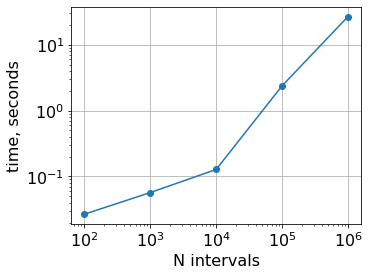

In [5]:
plt.loglog(
    list(timings.keys()),
    list([r.average for r in timings.values()]),
    'o-',
)
plt.xlabel('N intervals')
plt.ylabel('time, seconds')
plt.gca().set_aspect(1.0)
plt.grid()

### vs total number of intersections

Note that not only the number of intervals, but also the density of intervals determines the performance of overlap. 

In [6]:
timings = {}
n_intersections = {}
n = 1e4
for avg_interval_len in [3, 1e1, 3e1, 1e2, 3e2]:
    df = make_random_intervals(n=n, n_chroms=1, max_length=avg_interval_len*2)
    df2 = make_random_intervals(n=n, n_chroms=1, max_length=avg_interval_len*2)
    timings[avg_interval_len] = %timeit -o -r 1 bioframe.overlap(df, df2)
    n_intersections[avg_interval_len] = bioframe.overlap(df, df2).shape[0]

81.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
268 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
628 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.08 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


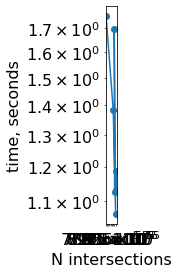

In [13]:
plt.loglog(
    list(n_intersections.values()),
    list([r.average for r in timings.values()]),
    'o-',
)
plt.xlabel('N intersections')
plt.ylabel('time, seconds')
plt.gca().set_aspect(1.0)
plt.grid()

### vs number of chromosomes

If we consider a genome of the same length, divided into more chromosomes, the timing is relatively unaffected.

In [14]:
timings = {}
n_intersections = {}
n = 1e5
for n_chroms in [1, 3, 10, 30, 100, 300, 1000]:
    df = make_random_intervals(n, n_chroms)
    df2 = make_random_intervals(n, n_chroms)
    timings[n_chroms] = %timeit -o -r 1 bioframe.overlap(df, df2)
    n_intersections[n_chroms] = bioframe.overlap(df, df2).shape[0]


1.41 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.29 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.17 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.69 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.12 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.67 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.28 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Note this test preserves the number of intersections, which is likely why performance remains similar over the considered range.

In [15]:
n_intersections

{1: 810032,
 3: 807868,
 10: 812042,
 30: 808075,
 100: 808861,
 300: 803974,
 1000: 785784}

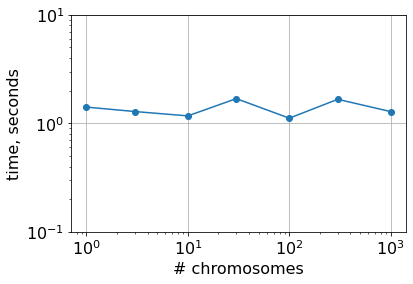

In [16]:
plt.loglog(
    list(timings.keys()),
    list([r.average for r in timings.values()]),
    'o-',
)
plt.ylim([1e-1, 10])
plt.xlabel('# chromosomes')
plt.ylabel('time, seconds')
# plt.gca().set_aspect(1.0)
plt.grid()

### vs other parameters: join type, sorted or categorical inputs

Note that default for overlap: `how='left', keep_order=True`, and the returned dataframe is sorted after the overlaps have been ascertained. Also note that `keep_order=True` is only a valid argument for `how='left'` as the order is not well-defined for inner or outer overlaps. 

In [17]:
df = make_random_intervals()
df2 = make_random_intervals()
%timeit -r 1 bioframe.overlap(df, df2)
%timeit -r 1 bioframe.overlap(df, df2, how='left', keep_order=False)

1.38 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
814 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [18]:
df = make_random_intervals()
df2 = make_random_intervals()

%timeit -r 1 bioframe.overlap(df, df2, how='outer')
%timeit -r 1 bioframe.overlap(df, df2, how='inner')
%timeit -r 1 bioframe.overlap(df, df2, how='left', keep_order=False)

814 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
640 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
862 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Note below that detection of overlaps takes a relatively small fraction of the execution time. The majority of the time the user-facing function spends on formatting the output table.

In [19]:
df = make_random_intervals()
df2 = make_random_intervals()

%timeit -r 1 bioframe.overlap(df, df2)
%timeit -r 1 bioframe.overlap(df, df2, how='inner')
%timeit -r 1 bioframe.ops._overlap_intidxs(df, df2)
%timeit -r 1 bioframe.ops._overlap_intidxs(df, df2, how='inner')

1.41 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
510 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
142 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
165 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


Note that sorting inputs provides a moderate speedup, as well as storing chromosomes as categoricals 

In [20]:
print('Default inputs (outer/inner joins):')
df = make_random_intervals()
df2 = make_random_intervals()

%timeit -r 1 bioframe.overlap(df, df2)
%timeit -r 1 bioframe.overlap(df, df2, how='inner')

print('Sorted inputs (outer/inner joins):')
df_sorted = make_random_intervals(sort=True)
df2_sorted = make_random_intervals(sort=True)

%timeit -r 1 bioframe.overlap(df_sorted, df2_sorted)
%timeit -r 1 bioframe.overlap(df_sorted, df2_sorted, how='inner')

print('Categorical chromosomes (outer/inner joins):')
df_cat = make_random_intervals(categorical_chroms=True)
df2_cat = make_random_intervals(categorical_chroms=True)

%timeit -r 1 bioframe.overlap(df_cat, df2_cat)
%timeit -r 1 bioframe.overlap(df_cat, df2_cat, how='inner')


Default inputs (outer/inner joins):
1.27 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
682 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Sorted inputs (outer/inner joins):
1.26 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
563 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Categorical chromosomes (outer/inner joins):
752 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
306 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Vs Pyranges

### Default arguments

The core intersection function of PyRanges is faster, since PyRanges object splits intervals by chromosomes at the object construction stage

In [9]:
def df2pr(df):
    return pyranges.PyRanges(
    chromosomes=df.chrom,
    starts=df.start,
    ends=df.end,
    )

In [22]:
timings_bf = {}
timings_pr = {}
for n in [1e2, 1e3, 1e4, 1e5, 1e6, 3e6]:
    df = make_random_intervals(n=n, n_chroms=1)
    df2 = make_random_intervals(n=n, n_chroms=1)
    pr = df2pr(df)
    pr2 = df2pr(df2)
    timings_bf[n] = %timeit -o -r 1 bioframe.overlap(df, df2,how='inner')
    timings_pr[n] = %timeit -o -r 1 pr.join(pr2)
    

7.92 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
3.53 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
8.29 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
4.08 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
34.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
11 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
357 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
105 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
5.39 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.58 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
19 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
6.41 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


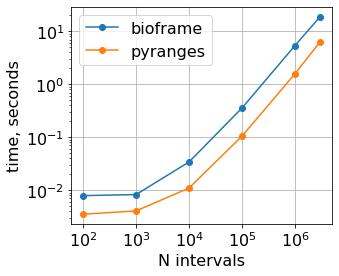

In [23]:
plt.loglog(
    list(timings_bf.keys()),
    list([r.average for r in timings_bf.values()]),
    'o-',
    label='bioframe'
)
plt.loglog(
    list(timings_pr.keys()),
    list([r.average for r in timings_pr.values()]),
    'o-',
    label='pyranges'
)

plt.gca().set(
    xlabel='N intervals',
    ylabel='time, seconds',
    aspect=1.0,
    xticks=10**np.arange(2,6.1)
)
plt.grid()
plt.legend()

### With roundtrips to dataframes

Note that pyranges performs useful calculations at the stage of creating a PyRanges object. Thus a direct comparison for one-off operations on pandas DataFrames between bioframe and pyranges should take this step into account. This roundrip is handled by `pyranges_intersect_dfs` below.

In [7]:
def pyranges_intersect_dfs(df, df2):
    return df2pr(df).intersect(df2pr(df2)).as_df()

In [18]:
timings_bf = {}
timings_pr = {}
for n in [1e2, 1e3, 1e4, 1e5, 1e6, 3e6]:
    df = make_random_intervals(n=n, n_chroms=1)
    df2 = make_random_intervals(n=n, n_chroms=1)
    timings_bf[n] = %timeit -o -r 1 bioframe.overlap(df, df2, how='inner')
    timings_pr[n] = %timeit -o -r 1 pyranges_intersect_dfs(df, df2)
    

7.27 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
11.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
9.22 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
12.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
30.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
25.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
319 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
168 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4.95 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.21 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
16.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
7.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


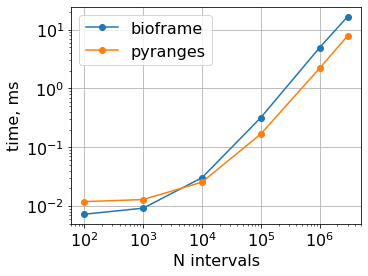

In [19]:
plt.loglog(
    list(timings_bf.keys()),
    list([r.average for r in timings_bf.values()]),
    'o-',
    label='bioframe'
)
plt.loglog(
    list(timings_pr.keys()),
    list([r.average for r in timings_pr.values()]),
    'o-',
    label='pyranges'
)
plt.gca().set(
    xlabel='N intervals',
    ylabel='time, seconds',
    aspect=1.0
)
plt.grid()
plt.legend()

### Memory usage

In [44]:
from memory_profiler import memory_usage
import time

def sleep_before_after(func, sleep_sec=0.5):
    def _f(*args, **kwargs):
        time.sleep(sleep_sec)
        func(*args, **kwargs)
        time.sleep(sleep_sec)
    return _f

mem_usage_bf = {}
mem_usage_pr = {}

for n in [1e2, 1e3, 1e4, 1e5, 1e6, 3e6]:
    df = make_random_intervals(n=n, n_chroms=1)
    df2 = make_random_intervals(n=n, n_chroms=1)
    mem_usage_bf[n] = memory_usage(
        (sleep_before_after(bioframe.overlap), (df, df2), dict( how='inner')), 
        backend='psutil', 
        include_children=True,
        interval=0.1,
    max_usage=True)
    mem_usage_pr[n] = memory_usage(
        (sleep_before_after(pyranges_intersect_dfs), (df, df2), dict()), 
        backend='psutil', 
        include_children=True,
        interval=0.1,
     max_usage=True)
    

(100, 10000)

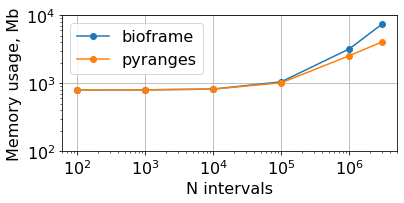

In [50]:
plt.figure(figsize=(6,6))
plt.loglog(
    list(mem_usage_bf.keys()),
    list(mem_usage_bf.values()),
    'o-',
    label='bioframe'
)

plt.loglog(
    list(mem_usage_pr.keys()),
    list(mem_usage_pr.values()),
    'o-',
    label='pyranges'
)

plt.gca().set(
    xlabel='N intervals',
    ylabel='Memory usage, Mb',
    aspect=1.0
)
plt.grid()
plt.legend()
plt.ylim([10**2,10**4])

In [43]:
plt.figure(figsize=(8,6))
plt.loglog(
    list(mem_usage_bf.keys()),
    list([max(r) - r[4] for r in mem_usage_bf.values()]),
    'o-',
    label='bioframe'
)

plt.loglog(
    list(mem_usage_pr.keys()),
    list([max(r) - r[4] for r in mem_usage_pr.values()]),
    'o-',
    label='pyranges'
)

plt.gca().set(
    xlabel='N intervals',
    ylabel='Memory usage, Mb',
    aspect=1.0
)
plt.grid()
plt.legend()

TypeError: 'float' object is not iterable

<Figure size 576x432 with 0 Axes>

The 2x memory consumption of bioframe is due to the fact that bioframe store genomic coordinates as int64 by default, while pyranges uses int32:

In [22]:
print('Bioframe dtypes:')
display(df.dtypes)
print()
print('Pyranges dtypes:')
display(df2pr(df).dtypes)


Bioframe dtypes:


chrom    object
start     int64
end       int64
dtype: object


Pyranges dtypes:


Chromosome    category
Start            int32
End              int32
dtype: object

In [ ]:
### Combined performance figure.

fig, axs = plt.subplot_mosaic(
    'AAA.BBB',
    figsize=(9.0,4))

plt.sca(axs['A'])                   

plt.text(-0.25, 1.0, 'A', horizontalalignment='center',
    verticalalignment='center', transform=plt.gca().transAxes,
        fontsize=19)

plt.loglog(
    list(timings_bf.keys()),
    list([r.average for r in timings_bf.values()]),
    'o-',
    color='k',
    label='bioframe'
)
plt.loglog(
    list(timings_pr.keys()),
    list([r.average for r in timings_pr.values()]),
    'o-',
    color='gray',
    label='pyranges'
)
plt.gca().set(
    xlabel='N intervals',
    ylabel='time, s',
    aspect=1.0,
    xticks=10**np.arange(2,6.1),
    yticks=10**np.arange(-3,0.1),

)

plt.grid()
plt.legend()

plt.sca(axs['B'])
plt.text(-0.33, 1.0, 'B', horizontalalignment='center',
    verticalalignment='center', transform=plt.gca().transAxes,
        fontsize=19)
plt.loglog(
    list(mem_usage_bf.keys()),
    list([max(r) - r[4] for r in mem_usage_bf.values()]),
    'o-',
    color='k',
    label='bioframe'
)

plt.loglog(
    list(mem_usage_pr.keys()),
    list([max(r) - r[4] for r in mem_usage_pr.values()]),
    'o-',
    color='gray',
    label='pyranges'
)
plt.gca().set(
    xlabel='N intervals',
    ylabel='Memory usage, Mb',
    aspect=1.0,
    xticks=10**np.arange(2,6.1),
)

plt.grid()
plt.legend()

### Slicing 

In [25]:
timings_slicing_bf = {}
timings_slicing_pr = {}


for n in [1e2, 1e3, 1e4, 1e5, 1e6, 3e6]:
    df = make_random_intervals(n=n, n_chroms=1)
    timings_slicing_bf[n] = %timeit -o -r 1 bioframe.select(df, ('chr1', n//2, n//4*3))
    pr = df2pr(df)
    timings_slicing_pr[n] = %timeit -o -r 1 pr['chr1', n//2:n//4*3]
    


2.59 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1.06 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
2.55 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1.35 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
4.25 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
4.21 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
14.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
30 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
159 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
357 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
397 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.13 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


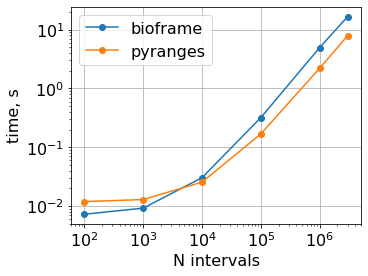

In [26]:
plt.loglog(
    list(timings_slicing_bf.keys()),
    list([r.average for r in timings_bf.values()]),
    'o-',
    label='bioframe'
)

plt.loglog(
    list(timings_slicing_pr.keys()),
    list([r.average for r in timings_pr.values()]),
    'o-',
    label='pyranges'
)
plt.gca().set(
    xlabel='N intervals',
    ylabel='time, s',
    aspect=1.0
)
plt.grid()
plt.legend()